In [1]:
import pandas as pd

import numpy as np

from numba import cuda

import pickle

import os

import cv2

from pycm import ConfusionMatrix

import time

import lwmw

import seaborn as sns

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Грузим данные 

1. Таблички

In [3]:
a = os.listdir("Dataset/Origin/")
b = os.listdir("Dataset/Expert/")
c = os.listdir("Dataset/sample_1/")
d = os.listdir("Dataset/sample_2/")
e = os.listdir("Dataset/sample_3/")

In [4]:
open_part = pd.read_csv("Dataset/OpenPart.csv")
shapes = pd.read_csv("Dataset/DX_TEST_RESULT_FULL.csv")

In [5]:
a = [x.split("_")[0] + "_" + x.split("_")[1].split(".")[0] for x in a]
b = [x.split("_")[0] + "_" + x.split("_")[1] for x in b]
c = [x.split("_")[0] + "_" + x.split("_")[1] for x in c]
e = [x.split("_")[0] + "_" + x.split("_")[1] for x in e]
f = [x.split("_")[0] + "_" + x.split("_")[1].split(".")[0] for x in list(open_part.Case.values)]

In [6]:
#проверка совпадения имен файлов
print(f"Соотносящихся элементов: {len(list(set(a) & set(b) & set(c) & set(e) & set(f)))}")

Соотносящихся элементов: 60


[]

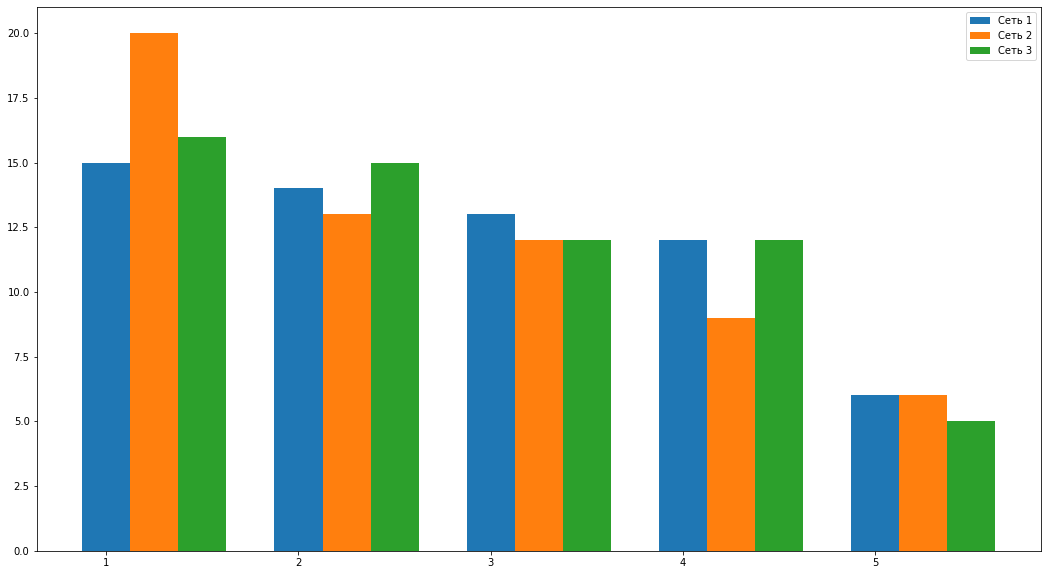

In [8]:
plt.figure(figsize=(18,10))
ind = np.arange(1, 6)
plt.bar(ind, open_part["Sample 1"].value_counts(), label="Сеть 1",  width = 0.25)
plt.bar(ind + 0.25, open_part["Sample 2"].value_counts(), label="Сеть 2",  width = 0.25)
plt.bar(ind + 0.50, open_part["Sample 3"].value_counts(), label="Сеть 3",  width = 0.25)
plt.legend(loc="upper right")
plt.plot()

2. Изображения

In [9]:
samples = {}

for sample in range(1,4):
    temp_names = os.listdir(f"Dataset/sample_{sample}/")
    img_buffer = []
    for img_name in temp_names:
        img_buffer.append(cv2.imread(f"Dataset/sample_{sample}/{img_name}") / 255.0)
    samples[f"sample_{sample}"] = img_buffer

In [10]:
print(len(samples["sample_1"]), len(samples["sample_2"]), len(samples["sample_3"]))

100 100 100


In [11]:
origin = []

temp_names = os.listdir(f"Dataset/Origin/")
for img_name in temp_names:
    origin.append(cv2.imread(f"Dataset/Origin/{img_name}") / 255.0)

In [12]:
print(len(origin))

100


In [13]:
expert = []

temp_names = os.listdir(f"Dataset/Expert/")
for img_name in temp_names:
    expert.append(cv2.imread(f"Dataset/Expert/{img_name}") / 255.0)
del temp_names

In [14]:
print(len(expert))

100


Сопоставляем имена и названия файлов

In [15]:
print("Проверка масок, Оригинальных изображений")
mismatch = 0

for sample in samples.keys():
    for img in range(len(samples[sample])):
        if samples[sample][img].shape != samples[sample][img].shape:
            mismatch += 1
            
for orig in range(len(origin)):
    if origin[orig].shape != origin[0].shape:
        mismatch += 1
    
for exp in range(len(expert)):
    if expert[exp].shape != expert[0].shape:
        mismatch += 1
    
print(f"Форма в разметке не совпадает в {mismatch} случаев")

Проверка масок, Оригинальных изображений
Форма в разметке не совпадает в 0 случаев


Проверка на "нулевые" картинки

In [16]:
clear = 0
for img in expert:
    if img.sum() == 0:
        clear += 1
print(f"Пустой разметки от эксперта {clear}")

Пустой разметки от эксперта 9


## == Считаем Метрики ==

In [17]:
def pixel_accuracy(nn, expert):
    return sum(nn * expert) / (sum(expert))

def Jaccard(nn, expert):
    return sum(nn * expert) / (sum(nn) + sum(expert) - sum(nn * expert))

def Sorensen(nn, expert):
    return (2 * sum(nn * expert)) / (sum(nn) + sum(expert))

def Kulchinski(nn, expert):
    return ((sum(nn * expert)) / 2) * (1 / sum(nn) + 1 / sum(expert))

def Simpson(nn, expert):
    return (2 * sum(nn * expert)) / (sum(nn) + sum(expert) - abs(sum(nn) - sum(expert)))

def Braun(nn, expert):
    return (2 * sum(nn * expert)) / (sum(nn) + sum(expert) + abs(sum(nn) - sum(expert)))

In [18]:
temp_names = os.listdir("Dataset/sample_3/")
metrics = pd.DataFrame()
for i in range(len(expert)):
    temp_overal = ConfusionMatrix(actual_vector=expert[i].ravel(),predict_vector=samples["sample_3"][i].ravel())
    temp_metrics = {  "name": temp_names[i],
                      "PA": pixel_accuracy(samples["sample_3"][i], expert[i]),
                      "Jaccard": Jaccard(samples["sample_3"][i], expert[i]),
                      "Sorensen": Sorensen(samples["sample_3"][i], expert[i]),
                      "Kulchinski": Kulchinski(samples["sample_3"][i], expert[i]),
                      "Simpson": Simpson(samples["sample_3"][i], expert[i]),
                      "Braun_Blanke": Braun(samples["sample_3"][i], expert[i])
                   }
    temp_overal = temp_overal.overall_stat
    for j in temp_overal.keys():
        temp_metrics[j] = temp_overal[j]
        
    metrics = metrics.append(temp_metrics, ignore_index=True)

/home/gpu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/home/gpu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/home/gpu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/home/gpu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [19]:
metrics = metrics.drop(columns=["95% CI", "P-Value", "Kappa 95% CI", "Overall J", "SOA4(Cicchetti)", "SOA1(Landis & Koch)", "SOA2(Fleiss)", "SOA3(Altman)", "SOA4(Cicchetti)", "SOA5(Cramer)", "SOA6(Matthews)", "Zero-one Loss", "Chi-Squared DF", "RR"])
metrics = metrics.replace(to_replace='None', value=np.nan).dropna(axis="columns")

### Данные для одной сети
чистим данные и соотносим их с csv

In [20]:
string = metrics.name[0].split("_")[0] + "_" + metrics.name[0].split("_")[1]
expert_index = list(set(metrics.name.str.split("_").str[0] + "_" + metrics.name.str.split("_").str[1]) & set(f))
metrics.name = metrics.name.str.split("_").str[0] + "_" + metrics.name.str.split("_").str[1]
metrics = metrics[metrics.name.isin(expert_index)]
metrics = metrics.set_index("name")
metrics = metrics.sort_index()
open_part.Case = open_part.Case.str.split("_").str[0] + "_" + open_part.Case.str.split("_").str[1].str.split(".").str[0]
open_part = open_part.set_index("Case")
open_part = open_part.sort_index()
metrics["expert"] = open_part["Sample 3"]
metrics = metrics.join(pd.get_dummies(metrics['expert']))
metrics = metrics.drop(columns=["expert"]).rename(columns={1 : "mark_1", 2 : "mark_2", 3 : "mark_3", 4 : "mark_4", 5 : "mark_5"})

### Дамп метрик и их чтение

In [21]:
#metrics.to_csv("metrics100_3.csv", index=False)

In [6]:
metrics = pd.read_csv("metrics100_1.csv")

In [7]:
metrics = metrics.append(pd.read_csv("metrics100_2.csv")).append(pd.read_csv("metrics100_3.csv"))

### Склеиваем таблицы метрик

In [8]:
corr = metrics[metrics.columns[:-5]].corr()

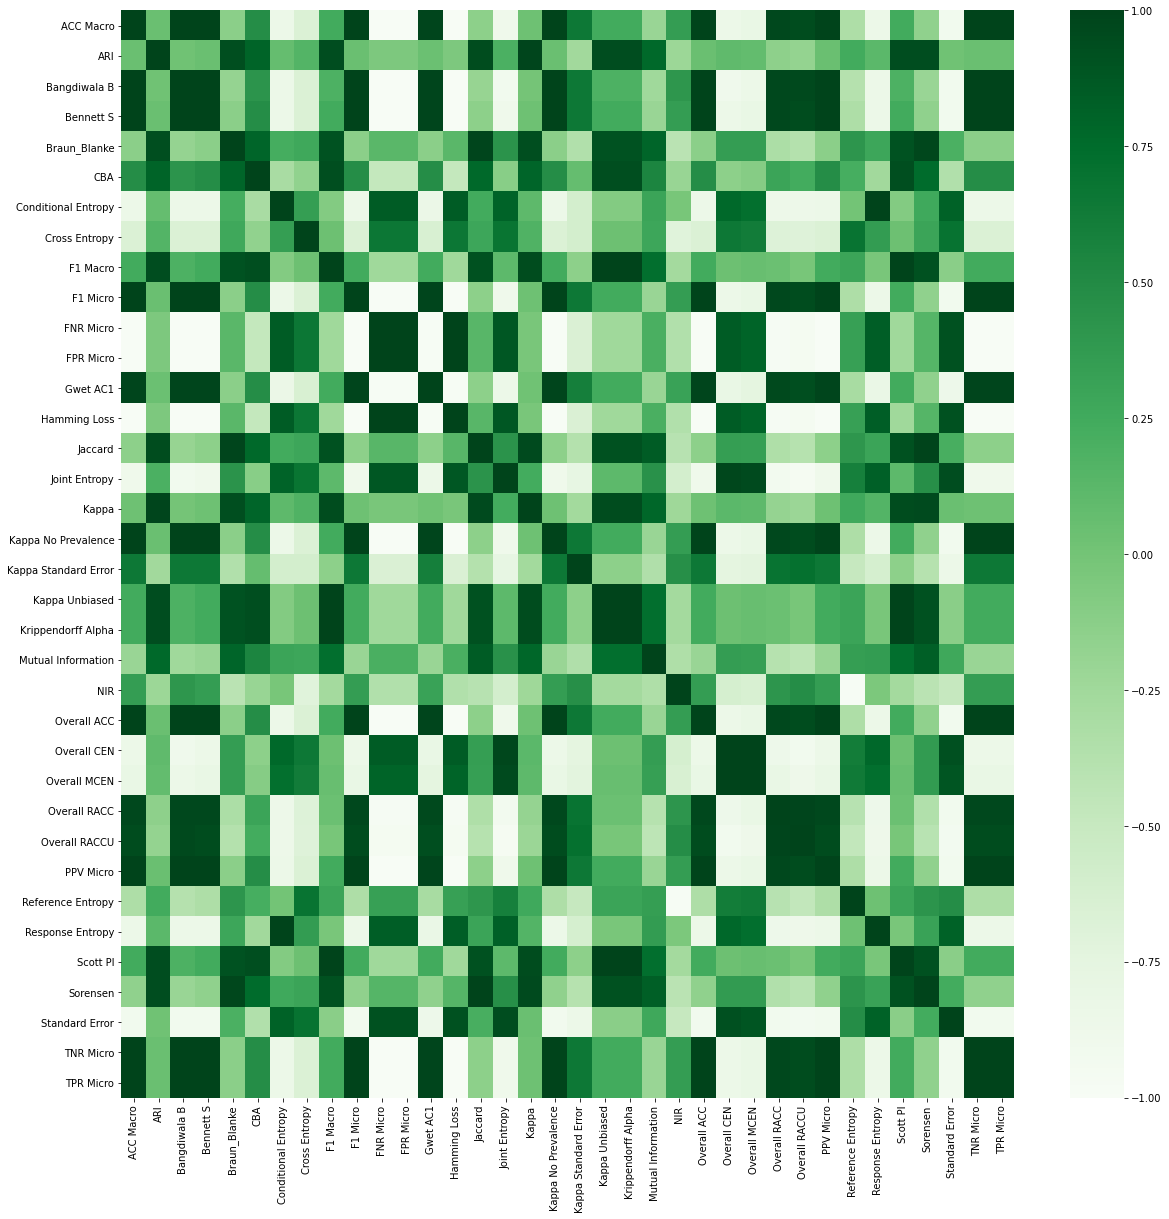

In [11]:
fig, ax = plt.subplots(1, figsize=(20,20))
sns.heatmap(corr, ax=ax, cmap="Greens")
plt.savefig("corr.png", dpi=300)
plt.show()

## Данные для всех сетей

## Учим нашу сеть

In [94]:
settings = {
    "outs" : 5,
    "input_len" : len(metrics),
    "architecture" : [22,12],
    "inputs" : len(metrics.columns) - 5,
    "activation" : "sigmoid",
    "gpu_name": "/gpu:1"
}

## ==== ВЫБИРАЕМ АРХИТЕКТУРУ! ====

In [12]:
%%time
history, p = lwmw.levmarq(
    settings, 
    x_train=metrics.values[:,:-5], 
    y_train=metrics.values[:,-5:], 
    mu_init=5.0, 
    min_error=2.8e-4, 
    max_steps=500, 
    mu_multiply=10, 
    mu_divide=10, 
    m_into_epoch=10, 
    verbose=True
)

=====>Training info<===== 

Settings: 
         outs:5
         input_len:180
         architecture:[13, 7]
         inputs:36
         activation:sigmoid
         gpu_name:/gpu:1

tf version:  1.15.0 

shape X:	(180, 36)
shape y:	(180, 5)
      m:	180
      p:	5


Complex:
        [parameters]x[data lenth]
        619x180

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

LM step: 100, mu: 5.00e-03, current loss: 1.30e-01
LM step: 200, mu: 5.00e-05, current loss: 9.10e-02
LM step: 300, mu: 5.00e-06, current loss: 6.89e-02
LM step: 400, mu: 5.00e-07, current loss: 5.86e-02
LM step: 500, mu: 5.00e-06, current loss: 5.33e-02
LevMarq ended on: 500,	final loss: 5.32e-02

CPU times:

In [18]:
plt.figure(figsize=(18,6))
plt.plot([10 * np.log10(2.8e-4)] * len(history), "r--", label="Критерий останова")
plt.plot(10 * np.log10(history), label = "Левенберг-Марквардт")
plt.xlabel("Эпохи обучения")
plt.ylabel("Ошибка, дБ")
plt.xlim([0,len(history)])
plt.title(f"Ошибка обучения на обучающей выборке")
plt.legend(loc='upper right')
plt.show()

NameError: name 'history' is not defined

<Figure size 1296x432 with 0 Axes>

### Переинициализации

In [92]:
with open('/home/gpu/lab/medical_research/arch_dump_large/many_hist.pickle', 'rb') as f:
    hist_many = pickle.load(f)

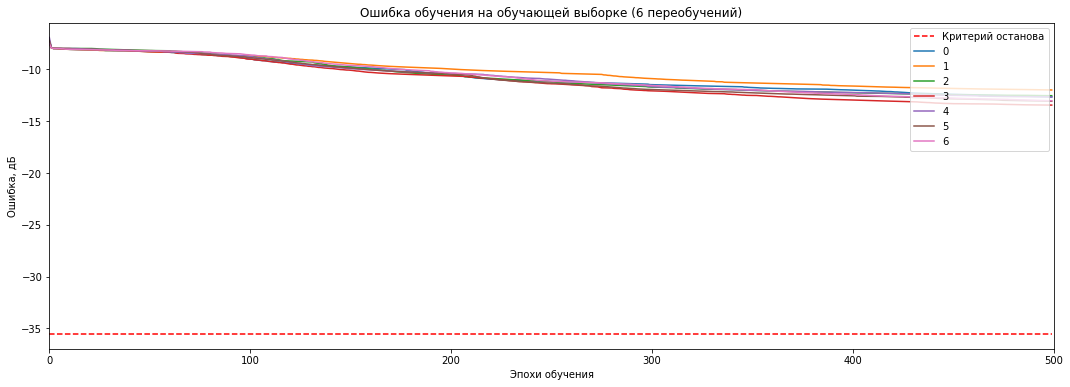

In [93]:
plt.figure(figsize=(18,6))
plt.plot([10 * np.log10(2.8e-4)] * 500, "r--", label="Критерий останова")
for hist in hist_many.keys():
    plt.plot(10 * np.log10(hist_many[hist]), label=hist)
plt.xlabel("Эпохи обучения")
plt.ylabel("Ошибка, дБ")
plt.xlim([0,500])
plt.title(f"Ошибка обучения на обучающей выборке (6 переобучений)")
plt.legend(loc="upper right")
plt.show()

## Аналитика по градиентам

In [11]:
with open('/home/gpu/lab/medical_research/arch_dump_large/p_many.pickle', 'rb') as f:
    p_many = pickle.load(f)

In [12]:
p_many.keys()

dict_keys([0])

In [14]:
device = cuda.get_current_device()
device.reset()
settings["gpu_name"] = "/gpu:2"

In [15]:
predicts, grads = lwmw.predict(p, settings, metrics.values[:,:-5])

In [16]:
for i in range(0, settings["outs"]):
    metrics["preds_" + str(i+1)] = predicts[:,i]
    metrics["delta_" + str(i)] = metrics["mark_" + str(i+1)] - metrics["preds_" + str(i+1)]

In [14]:
grads_to_plot = np.sqrt(np.sum(grads[0]**2, axis=0) / len(grads[0])) / np.sqrt(np.sum(grads[0]**2, axis=0) / len(grads[0])).max()

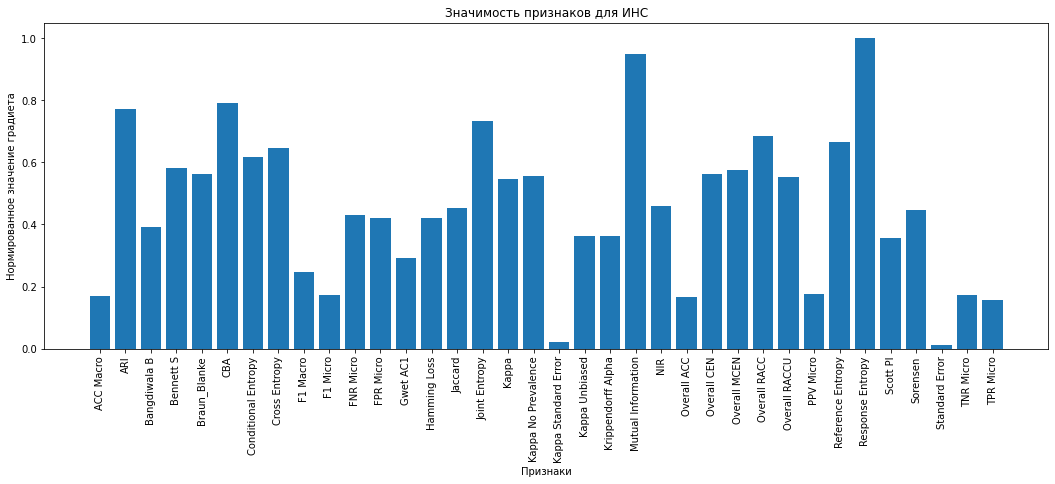

In [15]:
plt.figure(figsize=(18,6))
plt.bar(metrics.columns[:settings["inputs"]], grads_to_plot)
plt.xlabel("Признаки")
plt.ylabel("Нормированное значение градиета")
plt.title(f"Значимость признаков для ИНС")
plt.xticks(rotation=90)
plt.show()

## Сырые данные в l1 меру

In [15]:
#predictions = np.argmax(metrics[["preds_1", "preds_2", "preds_3", "preds_4", "preds_5"]].values, axis=1) + 1
expert_mark = np.argmax(metrics[["mark_1", "mark_2", "mark_3", "mark_4", "mark_5"]].values, axis=1) + 1

In [18]:
err = 0
for i in range(len(predictions)):
    err += np.abs(expert_mark[i] - predictions[i])
    
err = err / len(predictions)    
print(f"MAE: {err}")

MAE: 0.37222222222222223


## Тест на другой сети

## Тест на метрики

In [17]:
for met in metrics.columns[:36]:
    err = 0
    for i in range(len(expert_mark)):
        err += np.abs((expert_mark[i] / 5) - metrics[met].values[i])
    err = err / len(expert_mark)
    print(f"Ошибка для '{met}': {err}")

Ошибка для 'ACC Macro': 0.31316029866536427
Ошибка для 'ARI': 0.5841339007198488
Ошибка для 'Bangdiwala B': 0.3106545798918467
Ошибка для 'Bennett S': 0.29166336483425537
Ошибка для 'Braun_Blanke': 0.5648792478963119
Ошибка для 'CBA': 0.2733761873382361
Ошибка для 'Conditional Entropy': 0.389573124613811
Ошибка для 'Cross Entropy': 0.3791970688867395
Ошибка для 'F1 Macro': 0.2632198464765936
Ошибка для 'F1 Micro': 0.31316029866536427
Ошибка для 'FNR Micro': 0.52016021516588
Ошибка для 'FPR Micro': 0.52016021516588
Ошибка для 'Gwet AC1': 0.31121941332197633
Ошибка для 'Hamming Loss': 0.52016021516588
Ошибка для 'Jaccard': 0.5791634532208116
Ошибка для 'Joint Entropy': 0.3254410093715893
Ошибка для 'Kappa': 0.5774548162033161
Ошибка для 'Kappa No Prevalence': 0.29166336483425537
Ошибка для 'Kappa Standard Error': 0.6313290412476437
Ошибка для 'Kappa Unbiased': 0.6047764948809716
Ошибка для 'Krippendorff Alpha': 0.6047763432999407
Ошибка для 'Mutual Information': 0.6225817802438091
Ошибка

In [88]:
for met in ["Jaccard", "Sorensen"]:
    temp_met = []
    for i in range(len(expert_mark)):
        if metrics[met].values[i] >= 0.0 and metrics[met].values[i] <= 0.2:
            temp_met.append(1)
        if metrics[met].values[i] > 0.2 and metrics[met].values[i] <= 0.4:
            temp_met.append(2)
        if metrics[met].values[i] > 0.4 and metrics[met].values[i] <= 0.6:
            temp_met.append(3)
        if metrics[met].values[i] > 0.6 and metrics[met].values[i] <= 0.8:
            temp_met.append(4)
        if metrics[met].values[i] > 0.8 and metrics[met].values[i] <= 1.0:
            temp_met.append(5)
    err = 0
    not_in = 0
    for i in range(len(expert_mark)):
        err += np.abs(expert_mark[i] - temp_met[i])
        if expert_mark[i] != temp_met[i]:
            not_in += 1
    err = err / len(expert_mark)
    print(f"Ошибка для {met}: {round(err, 3)}, не совпало {not_in}, совпало {180-not_in}")

Ошибка для Jaccard: 2.094, не совпало 146, совпало 34
Ошибка для Sorensen: 2.0, не совпало 143, совпало 37


In [42]:
del temp_met

In [79]:
temp_met = []
for i in range(len(expert_mark)):
    if metrics["Jaccard"].values[i] >= 0.0 and metrics["Jaccard"].values[i] <= 0.2:
        temp_met.append(1)
    if metrics["Jaccard"].values[i] > 0.2 and metrics["Jaccard"].values[i] <= 0.4:
        temp_met.append(2)
    if metrics["Jaccard"].values[i] > 0.4 and metrics["Jaccard"].values[i] <= 0.6:
        temp_met.append(3)
    if metrics["Jaccard"].values[i] > 0.6 and metrics["Jaccard"].values[i] <= 0.8:
        temp_met.append(4)
    if metrics["Jaccard"].values[i] > 0.8 and metrics["Jaccard"].values[i] <= 1.0:
        temp_met.append(5)

In [86]:
err = 0
not_in = 0
for i in range(len(expert_mark)):
    err += np.abs(expert_mark[i] - temp_met[i])
    if expert_mark[i] != temp_met[i]:
        not_in += 1
err = err / len(expert_mark)
print(f"Ошибка для Jaccard: {round(err, 3)}, не совпало {not_in}, совпало {180-not_in}")

Ошибка для Jaccard: 2.094, не совпало 146, совпало 34


In [ ]:
for met in metrics.columns[:36]:
    err = 0
    for i in range(len(expert_mark)):
        err += np.abs((expert_mark[i] / 5) - metrics[met].values[i])
    err = err / len(expert_mark)
    print(f"Ошибка для '{met}': {err}")

In [4]:
import pickle
a = {}
with open('/home/gpu/lab/medical_research/arch_dump_large_22/many_hist.pickle', 'wb') as f:
    pickle.dump(settings, f)
    
with open('/home/gpu/lab/medical_research/arch_dump_large_22/many_hist.pickle', 'wb') as f:
    pickle.dump(a, f)
    
    with open('/home/gpu/lab/medical_research/arch_dump_large_22/many_hist.pickle', 'wb') as f:
    pickle.dump(a, f)